In [ ]:
# https://www.kaggle.com/code/harsha1999/rsna-2-5d-cnn-training-pytorch

In [1]:
import os

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pydicom as dcm
import nibabel as nib

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import Dataset
from torch import optim

In [2]:
path = "data/"

In [3]:
os.listdir(path)

['merged_df.csv', 'transformed_imgs.pkl']

### transformed 데이터 불러오기

In [3]:
import pickle

In [4]:
# full data 8.81GB으로 시스템 RAM 초과해서... ㅠㅠ 폭발 해버리네유 ㅠㅠ
# 로컬에서 작동할지도?!
with open(path + 'transformed_imgs.pkl', 'rb') as f:
    X = pickle.load(f)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


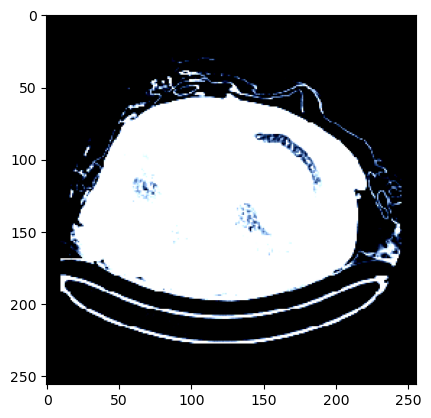

In [11]:
plt.imshow(X[5].permute(1,2,0));

### y값 데이터 불러오기

In [5]:
df = pd.read_csv(path + '/merged_df.csv')

In [7]:
df.head()

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,...,spleen_healthy,spleen_low,spleen_high,any_injury,series_id,instance_number,injury_name,path,aortic_hu,incomplete_organ
0,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,362,Active_Extravasation,train_images/10004/21057/362.dcm,146.0,0
1,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,363,Active_Extravasation,train_images/10004/21057/363.dcm,146.0,0
2,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,364,Active_Extravasation,train_images/10004/21057/364.dcm,146.0,0
3,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,365,Active_Extravasation,train_images/10004/21057/365.dcm,146.0,0
4,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,366,Active_Extravasation,train_images/10004/21057/366.dcm,146.0,0


In [ ]:
df.columns

Index(['patient_id', 'bowel_healthy', 'bowel_injury', 'extravasation_healthy',
       'extravasation_injury', 'kidney_healthy', 'kidney_low', 'kidney_high',
       'liver_healthy', 'liver_low', 'liver_high', 'spleen_healthy',
       'spleen_low', 'spleen_high', 'any_injury', 'series_id',
       'instance_number', 'injury_name', 'path', 'aortic_hu',
       'incomplete_organ'],
      dtype='object')

# train validation split

In [6]:
target_columns = ['bowel_healthy', 'bowel_injury',
                  'extravasation_healthy', 'extravasation_injury',
                  'kidney_healthy', 'kidney_low', 'kidney_high',
                  'liver_healthy', 'liver_low', 'liver_high',
                  'spleen_healthy', 'spleen_low', 'spleen_high']

In [7]:
y = df[target_columns]

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                    test_size=0.2, random_state=5)

In [20]:
len(X_train), len(X_val), y_train.shape, y_val.shape
# x_train : torch.Tensor # y_train : pandas.core.frame.DataFrame

(9623, 2406, (9623, 13), (2406, 13))

### DataLoader로 변화시키기

In [9]:
# 리스트를 PyTorch 텐서로 변환
x_train = torch.stack(X_train)
x_val = torch.stack(X_val)

In [10]:
train_dataset = TensorDataset(x_train, torch.Tensor(y_train.values))
val_dataset = TensorDataset(x_val, torch.Tensor(y_val.values))

In [11]:
BATCH_SIZE = 13  # 16, 3, 256, 256 --> 13, 3, 256, 256
################################################################
# batch_size = 16
# (torch.Size([16, 1]), torch.Size([2, 13])) shape error 나온다.
# ###############################################################
# batch_size = 13
# OutOfMemoryError: CUDA out of memory.

In [12]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
# batch_size=1

# model 설계


In [13]:
from torchvision import models

In [27]:
# Model Architecure
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.input = nn.Conv2d(3, 3, kernel_size = 3) # 1 input
        model = models.efficientnet_b0(weights = 'IMAGENET1K_V1')

        self.features = model.features # 2
        self.avgpool = model.avgpool # 3

        self.bowel = nn.Sequential(nn.Linear(1280, 2), nn.Sigmoid()) # 4 output
        self.extravasation = nn.Sequential(nn.Linear(1280, 2), nn.Sigmoid()) # 4
        self.kidney = nn.Sequential(nn.Linear(1280, 3), nn.Softmax()) # 4
        self.liver = nn.Sequential(nn.Linear(1280,3), nn.Softmax()) # 4
        self.spleen = nn.Sequential(nn.Linear(1280, 3), nn.Softmax()) # 4

    def forward(self, x):

        # extract features
        x = self.input(x)
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)

        # output logits
        bowel = self.bowel(x)
        extravsation = self.extravasation(x)
        kidney = self.kidney(x)
        liver = self.liver(x)
        spleen = self.spleen(x)

        return bowel, extravsation, kidney, liver, spleen

In [28]:
model = CNNModel().to('cuda')

In [41]:
target_columns[:2], target_columns[2:4], target_columns[4:7], target_columns[7:10], target_columns[10:]

(['bowel_healthy', 'bowel_injury'],
 ['extravasation_healthy', 'extravasation_injury'],
 ['kidney_healthy', 'kidney_low', 'kidney_high'],
 ['liver_healthy', 'liver_low', 'liver_high'],
 ['spleen_healthy', 'spleen_low', 'spleen_high'])

# Optimizer & Loss Function

In [16]:
LEARNING_RATE = 1e-4

In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [18]:
bce_bowel = nn.BCEWithLogitsLoss(pos_weight = torch.tensor([2.0]).to('cuda'))
bce_extra = nn.BCEWithLogitsLoss(pos_weight = torch.tensor([4.0]).to('cuda'))
ce_kls = nn.CrossEntropyLoss(label_smoothing = 0.05, weight = torch.tensor([1.0, 2.0, 4.0]).to('cuda'))

In [19]:
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, roc_auc_score

In [20]:
class MetricsCalculator:

    def __init__(self, mode = 'binary'):

        self.probabilities = []
        self.predictions = []
        self.targets = []

        self.mode = mode

    def update(self, logits, target):
        """
        Update the metrics calculator with predicted values and corresponding targets.

        Args:
            predicted (torch.Tensor): Predicted values.
            target (torch.Tensor): Ground truth targets.
        """
        if self.mode == 'binary':
            probabilities = torch.sigmoid(logits)
            predicted = (probabilities > 0.5)
        else:
            probabilities = F.softmax(logits, dim = 1)
            predicted = torch.argmax(probabilities, dim=1)

        self.probabilities.extend(probabilities.detach().cpu().numpy())
        self.predictions.extend(predicted.detach().cpu().numpy())
        self.targets.extend(target.detach().cpu().numpy())

    def reset(self):
        """Reset the stored predictions and targets."""

        self.probabilities = []
        self.predictions = []
        self.targets = []

    def compute_accuracy(self):
        """
        Compute the accuracy metric.

        Returns:
            float: Accuracy.
        """
        return accuracy_score(self.targets, self.predictions)

    def compute_auc(self):
        """
        Compute the AUC (Area Under the Curve) metric.

        Returns:
            float: AUC.
        """
        if self.mode == 'multi':
            return roc_auc_score(self.targets, self.probabilities, multi_class = 'ovo', labels=[0, 1, 2])

        else:
            return roc_auc_score(self.targets, self.probabilities)

In [21]:
# initialize metrics objects
train_acc_bowel = MetricsCalculator('binary')
train_acc_extravasation = MetricsCalculator('binary')
train_acc_liver = MetricsCalculator('multi')
train_acc_kidney = MetricsCalculator('multi')
train_acc_spleen = MetricsCalculator('multi')

val_acc_bowel = MetricsCalculator('binary')
val_acc_extravasation = MetricsCalculator('binary')
val_acc_liver = MetricsCalculator('multi')
val_acc_kidney = MetricsCalculator('multi')
val_acc_spleen = MetricsCalculator('multi')

# model.fit

In [22]:
EPOCHS = 10

In [42]:
target_columns[:2], target_columns[2:4], target_columns[4:7], target_columns[7:10], target_columns[10:]

(['bowel_healthy', 'bowel_injury'],
 ['extravasation_healthy', 'extravasation_injury'],
 ['kidney_healthy', 'kidney_low', 'kidney_high'],
 ['liver_healthy', 'liver_low', 'liver_high'],
 ['spleen_healthy', 'spleen_low', 'spleen_high'])

In [29]:
train_loss = []
val_loss = []
total_train_loss = []
total_val_loss = []


for epoch in tqdm(range(EPOCHS)):

    # training
    model.train()

    train_loss = 0.0
    val_loss = 0.0

    train_idx = 0
    
    for imgs, labels in train_loader:
        train_idx += 1
        
        inputs = imgs.to('cuda')
        bowel = labels[:2].to('cuda') # bowel
        extravasation = labels[2:4].to('cuda') # extravasation
        liver = labels[4:7].to('cuda') # liver
        kidney = labels[7:10].to('cuda') # kidney
        spleen = labels[10:].to('cuda') # spleen

        optimizer.zero_grad()
        b, e, k, l, s = model(inputs)
        b_train_loss = bce_bowel(b, bowel.float())
        e_train_loss = bce_extra(e, extravasation.float())
        l_train_loss = ce_kls(l, liver)
        k_train_loss = ce_kls(k, kidney)
        s_train_loss = ce_kls(s, spleen)

        # 각각의 loss 값 append
        train_loss.append(b_train_loss)
        train_loss.append(e_train_loss)
        train_loss.append(l_train_loss)
        train_loss.append(k_train_loss)
        train_loss.append(s_train_loss)


        total_loss = b_train_loss + e_train_loss + l_train_loss + k_train_loss + s_train_loss
        # total loss 값 append
        total_train_loss.append(total_loss)

        total_loss.backward()

        optimizer.step()

                # calculate training metrics
        train_loss += total_loss.item()
        train_acc_bowel.update(b, bowel)
        train_acc_extravasation.update(e, extravasation)
        train_acc_liver.update(l, liver)
        train_acc_kidney.update(k, kidney)
        train_acc_spleen.update(s, spleen)

        train_loss = train_loss/(train_idx+1)


        # validation
    model.eval()
    running_loss = 0.0
    
    val_idx = 0

    for val_img, val_labels in tqdm(val_loader):
        val_idx += 1
        
        inputs = val_img.to('cuda')
        bowel = val_labels[:2].to('cuda')
        extravasation = val_labels[2:4].to('cuda')
        liver = val_labels[4:7].to('cuda')
        kidney = val_labels[7:10].to('cuda')
        spleen = val_labels[10:].to('cuda')


        b, e, k, l, s = model(inputs)
        b_val_loss = bce_bowel(b, bowel.float())
        e_val_loss = bce_extra(e, extravasation.float())
        l_val_loss = ce_kls(l, liver)
        k_val_loss = ce_kls(k, kidney)
        s_val_loss = ce_kls(s, spleen)

        # 각각의 loss 값 append
        train_loss.append(b_val_loss)
        train_loss.append(e_val_loss)
        train_loss.append(l_val_loss)
        train_loss.append(k_val_loss)
        train_loss.append(s_val_loss)


        total_loss = b_val_loss + e_val_loss + l_val_loss + k_val_loss + s_val_loss
        # total loss 값 append
        total_train_loss.append(total_loss)

        # calculate validation metrics
        val_loss += total_loss.item()
        val_acc_bowel.update(b, bowel)
        val_acc_extravasation.update(e, extravasation)
        val_acc_liver.update(l, liver)
        val_acc_kidney.update(k, kidney)
        val_acc_spleen.update(s, spleen)


    val_loss = val_loss/(val_idx + 1)

  0%|          | 0/10 [00:00<?, ?it/s]


ValueError: Target size (torch.Size([2, 13])) must be the same as input size (torch.Size([13, 13]))